## <span id="2"></span> ** Importing Libraries and Reading the Dataset **

In [ ]:
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.core.display import display, HTML
sns.set_style('darkgrid')
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath = 'drive/MyDrive/Implementation/data_with_T_Z_B_P_noDup.csv'
df = pd.read_csv(filepath,  index_col = 0)
to_exclude=["Community.Name", "Avg_Consumption_per_person", 'NumOfConnected-ENORATE']
dataset_original=df.drop(to_exclude, axis=1)
dataset_original["month_int"]=dataset_original['calendar_month'].astype(str).str[4:].astype(np.int64)
dataset_original


,ID,consumption_unit_total,calendar_month,community,year,temperature,NumOfConnected-COMMELEC,NumOfConnected-FREENRESIE,NumOfConnected-FREERESIE,NumOfConnected-GOVTELEC,...,Private.Villa,Investment.Villa,Arabic.House,Public.Building,Industrial.Building,Other.Buildings,Total.Buildings,population,population_density,month_int
1,201704-111,4.539462e+06,201704,111,2017,30.8,28,0,0,13,...,0.0,0.0,0.0,4.0,0.0,0.0,6.0,1550.0,258.333333,4
2,201704-112,1.001234e+07,201704,112,2017,30.8,3000,0,0,22,...,0.0,0.0,12.0,185.0,0.0,0.0,401.0,6621.0,16.511222,4
3,201704-113,1.263421e+07,201704,113,2017,30.8,3158,0,0,4,...,0.0,0.0,21.0,55.0,0.0,0.0,383.0,14963.0,39.067885,4
4,201704-114,1.003799e+07,201704,114,2017,30.8,3317,0,0,4,...,0.0,0.0,1.0,157.0,0.0,0.0,332.0,2563.0,7.719880,4
5,201704-115,6.275032e+06,201704,115,2017,30.8,1304,0,0,8,...,0.0,0.0,0.0,33.0,0.0,0.0,106.0,3750.0,35.377358,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7418,202002-967,1.259622e+05,202002,967,2020,22.7,7,1,0,1,...,3.0,0.0,0.0,5.0,0.0,5.0,14.0,NaN,NaN,2
7419,202002-971,2.407988e+05,202002,971,2020,22.7,4,14,0,1,...,1.0,0.0,0.0,7.0,0.0,3.0,11.0,NaN,NaN,2
7420,202002-981,9.235249e+04,202002,981,2020,22.7,9,0,0,3,...,4.0,0.0,0.0,6.0,0.0,1.0,20.0,NaN,NaN,2
7421,202002-987,7.757116e+03,202002,987,2020,22.7,3,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,NaN,NaN,2


In [ ]:
dataset_original_copy = dataset_original.copy()

In [ ]:
dataset_original.loc[dataset_original.calendar_month  <201811 ,
                     "consumption_unit_total"] = dataset_original.consumption_unit_total/2

In [ ]:
dataset_original['month_int']= 1+(-1*np.cos((dataset_original['month_int']-1)*(2.*np.pi/12)))
dataset_original['month_int']

1       1.000000
2       1.000000
3       1.000000
4       1.000000
5       1.000000
          ...   
7418    0.133975
7419    0.133975
7420    0.133975
7421    0.133975
7422    0.133975
Name: month_int, Length: 7422, dtype: float64

In [ ]:
dataset_original.calendar_month=dataset_original.calendar_month.astype(str)

In [ ]:
dataset_original = dataset_original[dataset_original['calendar_month']!='201704']

In [ ]:
dataset_original.calendar_month=pd.to_datetime(dataset_original.calendar_month,format= "%Y%m")

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Text(0.5, 0, 'Commulative Consumption (KWh)')

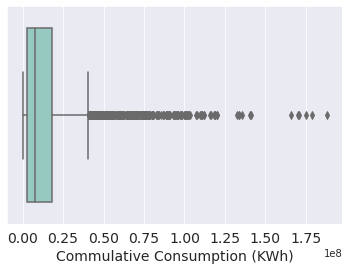

In [ ]:
#dataset = dataset.dropna(how='any',axis=0)
dataset_original=dataset_original.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
#Inspecting the vaalues
ax = sns.boxplot(x=dataset_original["consumption_unit_total"],palette="Set3")
#Now, removing the extreme values
ax.set(xlabel="Electricity Consumption (KWh)")


plt.xticks( fontsize=14)
plt.yticks( fontsize=14)
plt.xlabel("Commulative Consumption (KWh)", fontsize=14)


Text(0.5, 0, 'Commulative Consumption (KWh)')

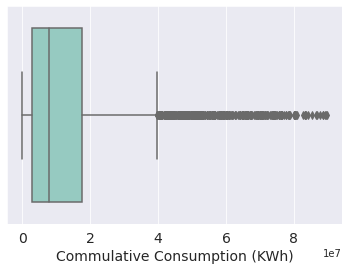

In [ ]:
#Removing the uper and lower 5% values
#https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
q_low = dataset_original["consumption_unit_total"].quantile(0.01)
q_hi  = dataset_original["consumption_unit_total"].quantile(0.99)
q_hi
dataset_original = dataset_original[  ((dataset_original["consumption_unit_total"] < q_hi) & (dataset_original["consumption_unit_total"] > q_low) )]
ax = sns.boxplot(x=dataset_original["consumption_unit_total"],palette="Set3")
ax.set(xlabel="Electricity Consumption (KWh)")


plt.xticks( fontsize=14)
plt.yticks( fontsize=14)
plt.xlabel("Commulative Consumption (KWh)", fontsize=14)

[Text(0, 0, '2017-05'),
 Text(0, 0, '2017-06'),
 Text(0, 0, '2017-07'),
 Text(0, 0, '2017-08'),
 Text(0, 0, '2017-09'),
 Text(0, 0, '2017-10'),
 Text(0, 0, '2017-11'),
 Text(0, 0, '2017-12'),
 Text(0, 0, '2018-01'),
 Text(0, 0, '2018-02'),
 Text(0, 0, '2018-03'),
 Text(0, 0, '2018-04'),
 Text(0, 0, '2018-05'),
 Text(0, 0, '2018-06'),
 Text(0, 0, '2018-07'),
 Text(0, 0, '2018-08'),
 Text(0, 0, '2018-09'),
 Text(0, 0, '2018-10'),
 Text(0, 0, '2018-11'),
 Text(0, 0, '2018-12'),
 Text(0, 0, '2019-01'),
 Text(0, 0, '2019-02'),
 Text(0, 0, '2019-03'),
 Text(0, 0, '2019-04'),
 Text(0, 0, '2019-05'),
 Text(0, 0, '2019-06'),
 Text(0, 0, '2019-07'),
 Text(0, 0, '2019-08'),
 Text(0, 0, '2019-09'),
 Text(0, 0, '2019-10'),
 Text(0, 0, '2019-11'),
 Text(0, 0, '2019-12')]

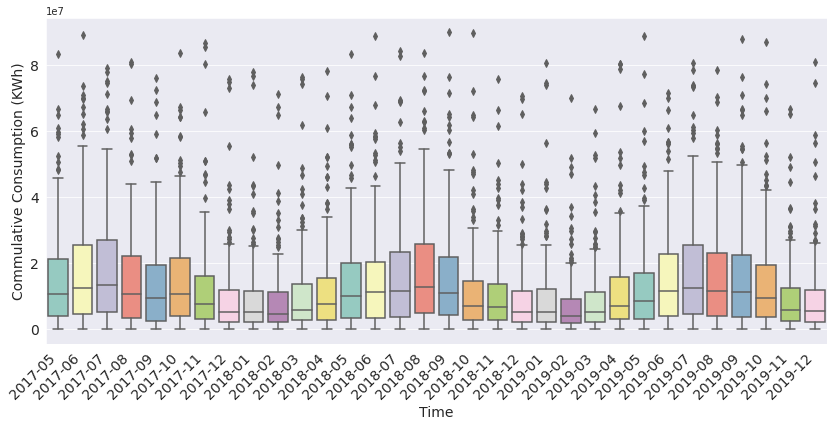

In [ ]:
f, axe = plt.subplots(1,1, figsize=(14,6))

sns.boxplot(x="calendar_month", y="consumption_unit_total",
                 data=dataset_original, palette="Set3", ax=axe)
axe.set(xlabel="Calendar Month", ylabel="Electricity Consumption (KWh)")

plt.xticks( fontsize=14, rotation=30)
plt.yticks( fontsize=14)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Commulative Consumption (KWh)", fontsize=14)

x_dates = dataset_original['calendar_month'].dt.strftime('%Y-%m').sort_values().unique()
axe.set_xticklabels(labels=x_dates, rotation=45, ha='right')


In [ ]:
to_plot_overall=dataset_original.copy()
to_plot_overall=to_plot_overall[["ID", "calendar_month", "consumption_unit_total"]]
to_plot_overall=to_plot_overall.groupby('calendar_month').sum().reset_index()
to_plot_overall[["calendar_month","consumption_unit_total"]].to_csv("temp.csv")

In [ ]:
#Normlaizing the output now:
output_values=dataset_original["consumption_unit_total"]
dataset_original["consumption_unit_total"]=((output_values-output_values.min())/(output_values.max()-output_values.min()))
ax.set(xlabel="Calendar Month", ylabel="Electricity Consumption (KWh)")


[Text(-3.8000000000000043, 0.5, 'Electricity Consumption (KWh)'),
 Text(0.5, 21.200000000000003, 'Calendar Month')]

In [ ]:
to_plot_overall=dataset_original.copy()
to_plot_overall=to_plot_overall[["ID", "calendar_month", "consumption_unit_total"]]
to_plot_overall=to_plot_overall.groupby('calendar_month').sum().reset_index()
to_plot_overall[["calendar_month","consumption_unit_total"]].to_csv("temp.csv")

### <span id="5"></span> ** Visualizing Data **


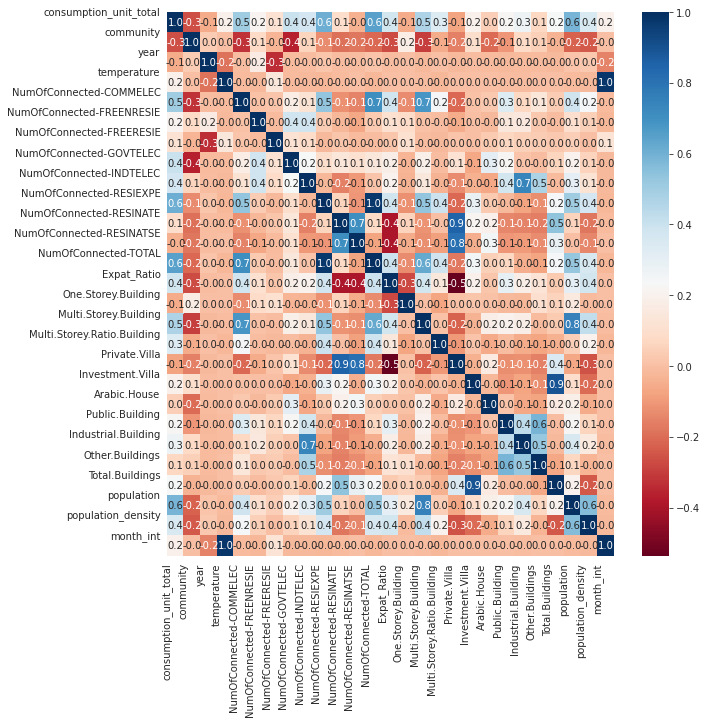

In [ ]:
corr = dataset_original.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".1f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

### <span id="3"></span> ** . Feature selection using filter method **

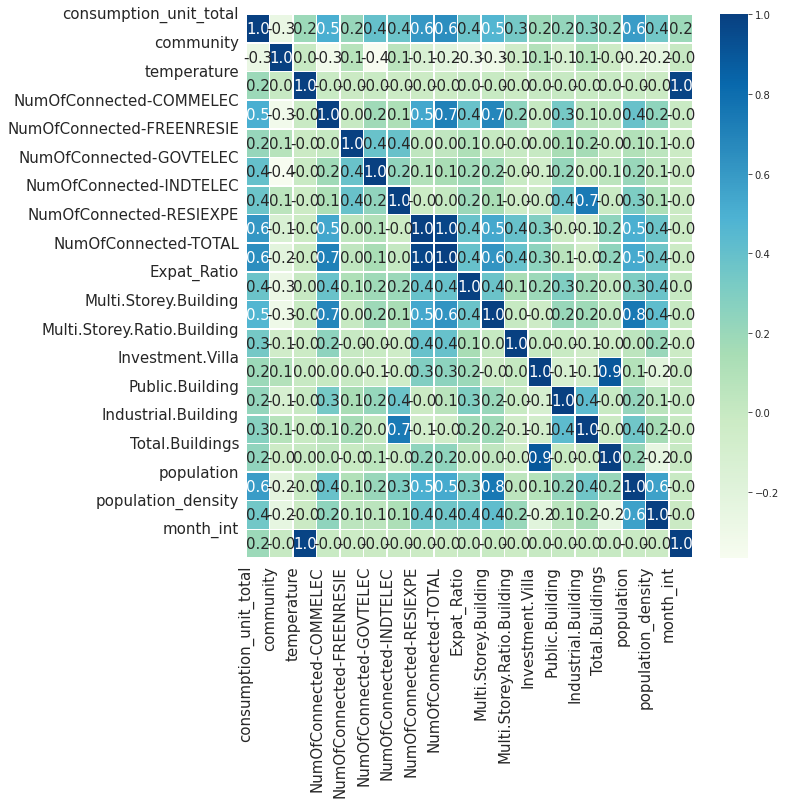

In [ ]:
# reference: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
#Correlation with output variable
cor_target = abs(corr["consumption_unit_total"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target.round(1)>=0.2].round(1)  # 0.2 is the threshold 
shortlisted=list(relevant_features.index)

dataset=dataset_original[shortlisted].copy()

# Now drawing hte updated heatmap
corr = dataset.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='GnBu', annot=True, fmt=".1f", linewidth=.5, annot_kws={'size':15})
#Apply xticks
colnames=shortlisted
plt.xticks(range(len(colnames)),colnames, fontsize=15);
#Apply yticks
plt.yticks(range(len(colnames)),colnames,fontsize=15)
#show plot
#legend(x="bottomright", legend=c("min", "ave", "max"))


plt.show()

In [ ]:
len(colnames)

19

### <span id="4"></span> ** Data Preprocessing **

Are there missing values? There isn't any missing values as shown below.

In [ ]:
X = dataset.drop(["consumption_unit_total"], axis=1)
y = dataset[["consumption_unit_total"]].values.reshape(-1,1)


In [ ]:
X

,community,temperature,NumOfConnected-COMMELEC,NumOfConnected-FREENRESIE,NumOfConnected-GOVTELEC,NumOfConnected-INDTELEC,NumOfConnected-RESIEXPE,NumOfConnected-TOTAL,Expat_Ratio,Multi.Storey.Building,Multi.Storey.Ratio.Building,Investment.Villa,Public.Building,Industrial.Building,Total.Buildings,population,population_density,month_int
208,112,33.7,3027,0,22,0,1060,4119,0.990654,204.0,0.0,0.0,185.0,0.0,401.0,6621.0,16.511222,1.500000
209,113,33.7,3191,0,4,0,1518,4719,0.996063,307.0,0.0,0.0,55.0,0.0,383.0,14963.0,39.067885,1.500000
210,114,33.7,3348,0,4,0,597,3950,0.998328,174.0,0.0,0.0,157.0,0.0,332.0,2563.0,7.719880,1.500000
211,115,33.7,1326,0,8,0,294,1628,1.000000,73.0,0.0,0.0,33.0,0.0,106.0,3750.0,35.377358,1.500000
212,116,33.7,2799,0,9,0,2422,5240,0.996298,250.0,0.0,0.0,20.0,0.0,281.0,18512.0,65.879004,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6953,945,23.6,1,1,1,0,0,11,0.000000,1.0,0.0,0.0,5.0,0.0,48.0,417.0,8.687500,0.133975
6954,951,23.6,15,3,2,0,3,35,0.200000,1.0,0.0,0.0,3.0,0.0,44.0,607.0,13.795455,0.133975
6955,961,23.6,31,2,11,0,3,99,0.054545,2.0,0.0,13.0,5.0,0.0,92.0,665.0,7.228261,0.133975
6956,967,23.6,7,0,1,0,0,12,0.000000,0.0,0.0,0.0,5.0,0.0,14.0,7.0,0.500000,0.133975


In [ ]:
# Splitting the dataset into the Training set and Test set
## Here we have two ways, Either Go RANDOM or SEQUENTIAL SPLIT
from sklearn.model_selection import train_test_split
split_method="random"
if (split_method=="random"):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
else:
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, shuffle=False)

# Self-Learning 

In [ ]:
shortlisted_sl=shortlisted+['calendar_month']
dataset_sl=dataset_original[shortlisted_sl]   
unique_months=dataset_sl['calendar_month'].unique()

In [ ]:
unique_months

array(['2017-05-01T00:00:00.000000000', '2017-06-01T00:00:00.000000000',
       '2017-07-01T00:00:00.000000000', '2017-08-01T00:00:00.000000000',
       '2017-09-01T00:00:00.000000000', '2017-10-01T00:00:00.000000000',
       '2017-11-01T00:00:00.000000000', '2017-12-01T00:00:00.000000000',
       '2018-01-01T00:00:00.000000000', '2018-02-01T00:00:00.000000000',
       '2018-03-01T00:00:00.000000000', '2018-04-01T00:00:00.000000000',
       '2018-05-01T00:00:00.000000000', '2018-06-01T00:00:00.000000000',
       '2018-07-01T00:00:00.000000000', '2018-08-01T00:00:00.000000000',
       '2018-09-01T00:00:00.000000000', '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000',
       '2019-03-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2019-05-01T00:00:00.000000000', '2019-06-01T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2019-08-01

### Moving CV for MLR, LaR, RR, NN, DT, SVR, Random Forest


In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

In [ ]:
from sklearn.metrics import r2_score


shortlisted_sl=shortlisted+['calendar_month']
dataset_sl=dataset_original[shortlisted_sl]   
unique_months=dataset_sl['calendar_month'].unique()
all_res_rmse=pd.DataFrame(columns=["Month Used for Testing", "Random Forest", "Decision Tree", "Neural Network", "Linear Regression", "Ridge Regression", "Lasso Regression", "Support Vector Regression"])
all_res_train=pd.DataFrame(columns=["Month Used for Testing", "Random Forest", "Decision Tree", "Neural Network", "Linear Regression", "Ridge Regression", "Lasso Regression", "Support Vector Regression"])
all_res_test=pd.DataFrame(columns=["Month Used for Testing", "Random Forest", "Decision Tree", "Neural Network", "Linear Regression", "Ridge Regression", "Lasso Regression", "Support Vector Regression"])
all_res_cv=pd.DataFrame(columns=["Month Used for Testing", "Random Forest", "Decision Tree", "Neural Network", "Linear Regression", "Ridge Regression", "Lasso Regression", "Support Vector Regression"])
all_res_mae=pd.DataFrame(columns=["Month Used for Testing", "Random Forest", "Decision Tree", "Neural Network", "Linear Regression", "Ridge Regression", "Lasso Regression", "Support Vector Regression"])
all_res_med_ae=pd.DataFrame(columns=["Month Used for Testing", "Random Forest", "Decision Tree", "Neural Network", "Linear Regression", "Ridge Regression", "Lasso Regression", "Support Vector Regression"])
all_res_time=pd.DataFrame(columns=["Month Used for Testing", "Random Forest", "Decision Tree", "Neural Network", "Linear Regression", "Ridge Regression", "Lasso Regression", "Support Vector Regression"])

    
    

    
    ##FOR MODEL # 1 ########################random forest#############################
    
    #Choose between moving and rolling
moving =False
for till_month_num in range(11,len(unique_months)-1):
    train_till=unique_months[till_month_num]
    test_this=unique_months[till_month_num+1]
    #test_this_till=unique_months[till_month_num+6]
    print("Training Till: "+ str(train_till))
    print("Testing for: "+ str(test_this))
    if moving==True:
        for_training=dataset_sl [(dataset_sl.calendar_month<= train_till) & (dataset_sl.calendar_month>= (unique_months[till_month_num-11])  )   ]
    else: #12 month Moving
        for_training=dataset_sl [dataset_sl.calendar_month<= train_till]
    print(for_training['calendar_month'].unique())
   # for_testing=dataset_sl [(dataset_sl.calendar_month>= test_this) & (dataset_sl.calendar_month<= test_this_till ) ]
    for_testing=dataset_sl [(dataset_sl.calendar_month== test_this) ]
    
    X_train=for_training.drop(["consumption_unit_total", "calendar_month"], axis=1)
    y_train=for_training[["consumption_unit_total"]].values.reshape(-1,1)
    
    ##Randomizing the training
    #X_train, X_test_JUNK, y_train, y_test_JUNK = train_test_split(X_train, y_train, test_size = 0.001, random_state = 25)
    ##
    
    X_test=for_testing.drop(["consumption_unit_total", "calendar_month"], axis=1)
    y_test=for_testing[["consumption_unit_total"]].values.reshape(-1,1)
    
    ## Now, this is where we fit the models and get results. 
    # Fitting the  Regression Model to the dataset
    #from sklearn.tree import DecisionTreeRegressor
    regressor_rf = RandomForestRegressor(n_estimators = 200, random_state = 0)
    t1 = timeit.default_timer() ##
    regressor_rf.fit(X_train, y_train.ravel())
    time_rf = timeit.default_timer() - t1
  # Predicting R2 Score the Train set results
    y_pred_rf_train = regressor_rf.predict(X_train)
    r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

    # Predicting R2 Score the Test set results
    y_pred_rf_test = regressor_rf.predict(X_test)
    r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

    # Predicting RMSE the Test set results
    rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
    #print('CV: ', cv_rf.mean())
    r2_score_rf_train = r2_score(y_train, y_pred_rf_train)
    r2_score_rf_test = r2_score(y_test, y_pred_rf_test)
    
    cv_rf = cross_val_score(estimator = regressor_rf, X = X_train, y = y_train.ravel(), cv = 10).mean()
    mae_rf = mean_absolute_error(y_test, y_pred_rf_test)
    med_ae_rf = median_absolute_error(y_test, y_pred_rf_test)

    
  ##FOR MODEL # 2 ###################decision trees############################################
    
    
    ## Now, this is where we fit the models and get results. 
    # Fitting the Decision Tree Regression Model to the dataset
    #from sklearn.tree import DecisionTreeRegressor
    regressor_dt = DecisionTreeRegressor(random_state = 0)
    t1 = timeit.default_timer() ##
    regressor_dt.fit(X_train, y_train)
    time_dt = timeit.default_timer() - t1

    ##
    y_pred_dt_train = regressor_dt.predict(X_train)
    r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

    # Predicting R2 Score the Test set results
    y_pred_dt_test = regressor_dt.predict(X_test)
    r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

    # Predicting RMSE the Test set results
    rmse_dt =  (np.sqrt(mean_squared_error(y_test,y_pred_dt_test)))
    r2_score_dt_train = r2_score(y_train, y_pred_dt_train)
    r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

    cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train.ravel(), cv = 10).mean()
    mae_dt = mean_absolute_error(y_test, y_pred_dt_test)
    med_ae_dt = median_absolute_error(y_test, y_pred_dt_test)


    
    
     ##FOR MODEL # 3 ###################neural network############################################
   
    
    
    #Scaling for neural Network
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    sc_X.fit(X_train)
    X_scaled_train = sc_X.transform(X_train)
    X_scaled_test = sc_X.transform(X_test)
    from sklearn.neural_network import MLPRegressor
    regressor_nn =MLPRegressor(alpha=0.0005, random_state=1, max_iter=2000, verbose=False, hidden_layer_sizes=(100,50,50), n_iter_no_change=20)
    t1 = timeit.default_timer()
    regressor_nn.fit(X_scaled_train, y_train.ravel())
    time_nn = timeit.default_timer() - t1
    from sklearn.metrics import r2_score

    # Predicting R2 Score the Train set results
    y_pred_nn_train = regressor_nn.predict(X_scaled_train)
    r2_score_nn_train = r2_score(y_train, y_pred_nn_train)

    # Predicting R2 Score the Test set results
    y_pred_nn_test = regressor_nn.predict(X_scaled_test)
    r2_score_nn_test = r2_score(y_test, y_pred_nn_test)

    # Predicting RMSE the Test set results
    rmse_nn = (np.sqrt(mean_squared_error(y_test, y_pred_nn_test)))

    r2_score_nn_train = r2_score(y_train, y_pred_nn_train)
    r2_score_nn_test = r2_score(y_test, y_pred_nn_test)

    cv_nn = cross_val_score(estimator = regressor_nn, X = X_scaled_train, y = y_train.ravel(), cv = 10).mean()

    mae_nn = mean_absolute_error(y_test, y_pred_nn_test)
    med_ae_nn = median_absolute_error(y_test, y_pred_nn_test)


    ##FOR MODEL # 4 ###################Linear Regression############################################
    
    
    ## Now, this is where we fit the models and get results. 
    # Fitting the Decision Tree Regression Model to the dataset
    from sklearn.linear_model import LinearRegression
    regressor_linear = LinearRegression()
    t1 = timeit.default_timer()
    regressor_linear.fit(X_train, y_train)
    time_linear = timeit.default_timer() - t1
    

    # Predicting R2 Score the Train set results
    y_pred_linear_train = regressor_linear.predict(X_train)
    r2_score_linear_train = r2_score(y_train, y_pred_linear_train)

    # Predicting R2 Score the Test set results
    y_pred_linear_test = regressor_linear.predict(X_test)
    r2_score_linear_test = r2_score(y_test, y_pred_linear_test)

    # Predicting RMSE the Test set results
    rmse_linear =  (np.sqrt(mean_squared_error(y_test,y_pred_linear_test)))
    r2_score_linear_train = r2_score(y_train, y_pred_linear_train)
    r2_score_linear_test = r2_score(y_test, y_pred_linear_test)

    cv_linear = cross_val_score(estimator = regressor_linear, X = X_train, y = y_train.ravel(), cv = 10).mean()
    mae_linear = mean_absolute_error(y_test, y_pred_linear_test)
    med_ae_linear = median_absolute_error(y_test, y_pred_linear_test)

    ##FOR MODEL # 5 ###################Ridge Regression ############################################
    
    steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge(alpha=3.8, fit_intercept=True))
    ]
    ridge_pipe = Pipeline(steps)
    t1 = timeit.default_timer()
    ridge_pipe.fit(X_train, y_train)
    time_ridge = timeit.default_timer() - t1
    
    # Predicting R2 Score the Test set results
    y_pred_ridge_train = ridge_pipe.predict(X_train)
    r2_score_ridge_train = r2_score(y_train, y_pred_ridge_train)

    # Predicting R2 Score the Test set results
    y_pred_ridge_test = ridge_pipe.predict(X_test)
    r2_score_ridge_test = r2_score(y_test, y_pred_ridge_test)

    # Predicting RMSE the Test set results
    rmse_ridge =  (np.sqrt(mean_squared_error(y_test,y_pred_ridge_test)))
    r2_score_ridge_train = r2_score(y_train, y_pred_ridge_train)
    r2_score_ridge_test = r2_score(y_test, y_pred_ridge_test)

    cv_ridge = cross_val_score(estimator = ridge_pipe, X = X_train, y = y_train.ravel(), cv = 10).mean()
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge_test)
    med_ae_ridge = median_absolute_error(y_test, y_pred_ridge_test)

    ##FOR MODEL # 6 ###################Lasso Regression ############################################
    
    steps = [
        ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('model', Lasso(alpha=0.012, fit_intercept=True, max_iter=3000))
    ]

    lasso_pipe = Pipeline(steps)
    start = timeit.default_timer() ##
    
    t1 = timeit.default_timer()
    lasso_pipe.fit(X_train, y_train)
    time_lasso = timeit.default_timer() - t1

    # Predicting Cross Validation Score
    

    # Predicting R2 Score the Test set results
    y_pred_lasso_train = lasso_pipe.predict(X_train)
    r2_score_lasso_train = r2_score(y_train, y_pred_lasso_train)

    # Predicting R2 Score the Test set results
    y_pred_lasso_test = lasso_pipe.predict(X_test)
    r2_score_lasso_test = r2_score(y_test, y_pred_lasso_test)

    # Predicting RMSE the Test set results
    rmse_lasso =  (np.sqrt(mean_squared_error(y_test,y_pred_lasso_test)))
    r2_score_lasso_train = r2_score(y_train, y_pred_lasso_train)
    r2_score_lasso_test = r2_score(y_test, y_pred_lasso_test)

    cv_lasso = cross_val_score(estimator = lasso_pipe, X = X_train, y = y_train.ravel(), cv = 10).mean()
    mae_lasso = mean_absolute_error(y_test, y_pred_lasso_test)
    med_ae_lasso = median_absolute_error(y_test, y_pred_lasso_test)
    
   ##FOR MODEL # 7 ###################Support Vector Regression ############################################
    regressor_svr = SVR(kernel = 'rbf',degree=3,C=1.5, epsilon=0.1, gamma=1e-7)
    
    t1 = timeit.default_timer()
    regressor_svr.fit(X_train, y_train.ravel())
    time_svr = timeit.default_timer() - t1
    
        # Predicting Cross Validation Score
    

    # Predicting R2 Score the Train set results
    y_pred_svr_train = (regressor_svr.predict((X_train)))
    r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

    # Predicting R2 Score the Test set results
    y_pred_svr_test = (regressor_svr.predict((X_test)))
    r2_score_svr_test = r2_score(y_test, y_pred_svr_test)


    # Predicting RMSE the Test set results
    rmse_svr =  (np.sqrt(mean_squared_error(y_test,y_pred_svr_test)))
    r2_score_svr_train = r2_score(y_train, y_pred_svr_train)
    r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

    cv_svr = cross_val_score(estimator = regressor_svr, X = X_train, y = y_train.ravel(), cv = 10).mean()
    mae_svr = mean_absolute_error(y_test, y_pred_svr_test)
    med_ae_svr = median_absolute_error(y_test, y_pred_svr_test)

    print("....................................")
    one_res_rmse={"Month Used for Testing":test_this,"Random Forest": rmse_rf ,
                  "Decision Tree": rmse_dt, "Neural Network":rmse_nn, "Linear Regression":rmse_linear,
                  "Ridge Regression":rmse_ridge, "Lasso Regression":rmse_lasso,
                  "Support Vector Regression":rmse_svr  }
    one_res_r2_train={"Month Used for Testing":test_this,"Random Forest": r2_score_rf_train ,
                      "Decision Tree": r2_score_dt_train, "Neural Network":r2_score_nn_train, 
                      "Linear Regression":r2_score_linear_train, "Ridge Regression":r2_score_ridge_train,
                      "Lasso Regression":r2_score_lasso_train, 
                      "Support Vector Regression":r2_score_svr_train  }
    one_res_r2_test={"Month Used for Testing":test_this,"Random Forest": r2_score_rf_test , 
                     "Decision Tree": r2_score_dt_test, "Neural Network":r2_score_nn_test,
                     "Linear Regression":r2_score_linear_test, "Ridge Regression":r2_score_ridge_test, 
                     "Lasso Regression":r2_score_lasso_test, "Support Vector Regression":r2_score_svr_test  }
    one_res_cv={"Month Used for Testing":test_this,"Random Forest": cv_rf , "Decision Tree": cv_dt,
                "Neural Network":cv_nn, "Linear Regression":cv_linear, "Ridge Regression":cv_ridge,
                "Lasso Regression":cv_lasso, "Support Vector Regression":cv_svr  }
    one_res_mae={"Month Used for Testing":test_this,"Random Forest": mae_rf , "Decision Tree": mae_dt,
                 "Neural Network":mae_nn, "Linear Regression":mae_linear, "Ridge Regression":mae_ridge,
                 "Lasso Regression":mae_lasso, "Support Vector Regression":mae_svr  }
    one_res_med_ae={"Month Used for Testing":test_this,"Random Forest": med_ae_rf , 
                    "Decision Tree": med_ae_dt, "Neural Network":med_ae_nn,
                    "Linear Regression":med_ae_linear, "Ridge Regression":med_ae_ridge,
                    "Lasso Regression":med_ae_lasso, "Support Vector Regression":med_ae_svr  }
    one_res_time={"Month Used for Testing":test_this,"Random Forest": time_rf , 
                    "Decision Tree": time_dt, "Neural Network":time_nn,
                    "Linear Regression":time_linear, "Ridge Regression":time_ridge,
                    "Lasso Regression":time_lasso, "Support Vector Regression":time_svr  }
    
    
    all_res_rmse=all_res_rmse.append(one_res_rmse,ignore_index=True)
    all_res_train=all_res_train.append(one_res_r2_train,ignore_index=True)
    all_res_test=all_res_test.append(one_res_r2_test,ignore_index=True)
    
    all_res_cv=all_res_cv.append(one_res_cv,ignore_index=True)
    all_res_mae=all_res_mae.append(one_res_mae,ignore_index=True)
    all_res_med_ae=all_res_med_ae.append(one_res_med_ae,ignore_index=True)
    all_res_time=all_res_time.append(one_res_time,ignore_index=True)
    


In [ ]:
#Saving the dataset
import xlsxwriter
writer = pd.ExcelWriter(filepath+'/Rolling - 7 Models.xlsx', engine='xlsxwriter')

all_res_rmse.to_excel(writer, sheet_name='RMSE')
all_res_train.to_excel(writer, sheet_name='R-squared Train')
all_res_test.to_excel(writer, sheet_name='R-squared Test')

all_res_cv.to_excel(writer, sheet_name='Cross Validation')
all_res_mae.to_excel(writer, sheet_name='Mean Absolute Error')
all_res_med_ae.to_excel(writer, sheet_name='Median Absolute Error')
all_res_time.to_excel(writer, sheet_name='Time')



writer.save()


### Rolling CV for XGB, LightGBM, GBM

In [ ]:
from sklearn.metrics import r2_score
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
    # Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

columns_nam = ["Month Used for Testing",  'XGB','LGB', 'GBM']
shortlisted_sl=shortlisted+['calendar_month']
dataset_sl=dataset_original[shortlisted_sl]   
unique_months=dataset_sl['calendar_month'].unique()
all_res_rmse=pd.DataFrame(columns=columns_nam)
all_res_train=pd.DataFrame(columns=columns_nam)
all_res_test=pd.DataFrame(columns=columns_nam)
all_res_cv=pd.DataFrame(columns=columns_nam)
all_res_mae=pd.DataFrame(columns=columns_nam)
all_res_med_ae=pd.DataFrame(columns=columns_nam)
all_res_time=pd.DataFrame(columns=columns_nam)

    
    #Choose between moving and rolling
moving =False
for till_month_num in range(11,len(unique_months)-1):
    train_till=unique_months[till_month_num]
    test_this=unique_months[till_month_num+1]
    #test_this_till=unique_months[till_month_num+6]
    print("Training Till: "+ str(train_till))
    print("Testing for: "+ str(test_this))
    if moving==True:
        for_training=dataset_sl [(dataset_sl.calendar_month<= train_till) & (dataset_sl.calendar_month>= (unique_months[till_month_num-11])  )   ]
    else: #12 month Moving
        for_training=dataset_sl [dataset_sl.calendar_month<= train_till]
    print(for_training['calendar_month'].unique())
   # for_testing=dataset_sl [(dataset_sl.calendar_month>= test_this) & (dataset_sl.calendar_month<= test_this_till ) ]
    for_testing=dataset_sl [(dataset_sl.calendar_month== test_this) ]
    
    X_train=for_training.drop(["consumption_unit_total", "calendar_month"], axis=1)
    y_train=for_training[["consumption_unit_total"]].values.reshape(-1,1)
    
    ##Randomizing the training
    #X_train, X_test_JUNK, y_train, y_test_JUNK = train_test_split(X_train, y_train, test_size = 0.001, random_state = 25)
    ##
    
    X_test=for_testing.drop(["consumption_unit_total", "calendar_month"], axis=1)
    y_test=for_testing[["consumption_unit_total"]].values.reshape(-1,1)
    
    ## Now, this is where we fit the models and get results. 


    
    ########################XGB#############################

    model_xgb = xgb.XGBRegressor()

    start = timeit.default_timer() ##
    model_xgb.fit(X_train, y_train)
    stop = timeit.default_timer() ##
    time_xgb=(stop - start)*1000 ##


    # Predicting Cross Validation Score the Test set results
    cv_xgb = cross_val_score(estimator = model_xgb, X = X_train, y = y_train, cv = 10)

    # Predicting R2 Score the Train set results
    y_pred_xgb_train = model_xgb.predict(X_train)
    r2_score_xgb_train = r2_score(y_train, y_pred_xgb_train)

    # Predicting R2 Score the Test set results
    y_pred_xgb_test = model_xgb.predict(X_test)
    r2_score_xgb_test = r2_score(y_test, y_pred_xgb_test)

    # Predicting RMSE the Test set results
    rmse_xgb =  (np.sqrt(mean_squared_error(y_test,y_pred_xgb_test)))
    mae_xgb = mean_absolute_error(y_test,y_pred_xgb_test)
    med_ae_xgb = median_absolute_error(y_test,y_pred_xgb_test)
    
        
    ########################LGB#############################
    
    model_lgb = LGBMRegressor()
    # evaluate the model
    start = timeit.default_timer() ##
    model_lgb.fit(X_train, pd.DataFrame(y_train))
    stop = timeit.default_timer() ##
    time_lgb=(stop - start)*1000 ##

    cv_lgb = cross_val_score(model_lgb, X = X_train, y = pd.DataFrame(y_train), cv=10)

    y_pred_lgb_train = model_lgb.predict(X_train)
    r2_score_lgb_train = r2_score(y_train, y_pred_lgb_train)

    # Predicting R2 Score the Test set results
    y_pred_lgb_test = model_lgb.predict(X_test)
    r2_score_lgb_test = r2_score(y_test, y_pred_lgb_test)

    # Predicting RMSE the Test set results
    rmse_lgb =  (np.sqrt(mean_squared_error(y_test,y_pred_lgb_test)))

    mae_lgb = mean_absolute_error(y_test,y_pred_lgb_test)
    med_ae_lgb = median_absolute_error(y_test,y_pred_lgb_test)


    ########################GBM#############################


    model_gbm= GradientBoostingRegressor(learning_rate=0.1,random_state=1)

    start = timeit.default_timer() ##
    model_gbm.fit(X_train, pd.DataFrame(y_train))
    stop = timeit.default_timer() ##
    time_gbm=(stop - start)*1000 ##


    # Predicting Cross Validation Score the Test set results
    cv_gbm = cross_val_score(estimator = model_gbm, X = X_train, y =y_train, cv = 10)

    # Predicting R2 Score the Train set results
    y_pred_gbm_train = model_gbm.predict(X_train)
    r2_score_gbm_train = r2_score(y_train, y_pred_gbm_train)

    # Predicting R2 Score the Test set results
    y_pred_gbm_test = model_gbm.predict(X_test)
    r2_score_gbm_test = r2_score(y_test, y_pred_gbm_test)

    # Predicting RMSE the Test set results
    rmse_gbm =  (np.sqrt(mean_squared_error(y_test,y_pred_gbm_test)))

    mae_gbm = mean_absolute_error(y_test,y_pred_gbm_test)
    med_ae_gbm = median_absolute_error(y_test,y_pred_gbm_test)


    ########################STK#############################


    

    print("....................................")
    one_res_rmse={"Month Used for Testing":test_this,    
                   'XGB':rmse_xgb,
                  'LGB':rmse_lgb, 'GBM':rmse_gbm}
    
    one_res_r2_train={"Month Used for Testing":test_this,
                      'XGB':r2_score_xgb_train,
                      'LGB':r2_score_lgb_train, 'GBM':r2_score_gbm_train }
    
    one_res_r2_test={"Month Used for Testing":test_this, 
                     'XGB':r2_score_xgb_test,
                     'LGB':r2_score_lgb_test, 'GBM':r2_score_gbm_test}
    
    one_res_cv={"Month Used for Testing":test_this,  
                'XGB':cv_xgb.mean(),
                'LGB':cv_lgb.mean(), 'GBM':cv_gbm.mean()}
    
    one_res_mae={"Month Used for Testing":test_this, 
                  'XGB':mae_xgb,
                 'LGB':mae_lgb, 'GBM':mae_gbm}
    
    one_res_med_ae={"Month Used for Testing":test_this,
                     'XGB':med_ae_xgb,
                    'LGB':med_ae_lgb, 'GBM':med_ae_gbm}
    
    one_res_time={"Month Used for Testing":test_this,  
                   'XGB':time_xgb,
                  'LGB':time_lgb, 'GBM':time_gbm}
    
    
    all_res_rmse=all_res_rmse.append(one_res_rmse,ignore_index=True)
    all_res_train=all_res_train.append(one_res_r2_train,ignore_index=True)
    all_res_test=all_res_test.append(one_res_r2_test,ignore_index=True)
    
    all_res_cv=all_res_cv.append(one_res_cv,ignore_index=True)
    all_res_mae=all_res_mae.append(one_res_mae,ignore_index=True)
    all_res_med_ae=all_res_med_ae.append(one_res_med_ae,ignore_index=True)
    all_res_time=all_res_time.append(one_res_time,ignore_index=True)
    

In [ ]:
#Saving the dataset
import xlsxwriter
writer = pd.ExcelWriter('3-models_all_months_Rolling_.xlsx', engine='xlsxwriter')

all_res_rmse.to_excel(writer, sheet_name='RMSE')
all_res_train.to_excel(writer, sheet_name='R-squared Train')
all_res_test.to_excel(writer, sheet_name='R-squared Test')

all_res_cv.to_excel(writer, sheet_name='Cross Validation')
all_res_mae.to_excel(writer, sheet_name='Mean Absolute Error')
all_res_med_ae.to_excel(writer, sheet_name='Median Absolute Error')
all_res_time.to_excel(writer, sheet_name='Time')


writer.save()


### Rolling CV for STK

In [ ]:
   
#for_trainingfrom sklearn.metrics import r2_score
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
    # Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

columns_nam = ["Month Used for Testing",  'stk']
shortlisted_sl=shortlisted+['calendar_month']
dataset_sl=dataset_original[shortlisted_sl]   
unique_months=dataset_sl['calendar_month'].unique()
all_res_rmse=pd.DataFrame(columns=columns_nam)
all_res_train=pd.DataFrame(columns=columns_nam)
all_res_test=pd.DataFrame(columns=columns_nam)
all_res_cv=pd.DataFrame(columns=columns_nam)
all_res_mae=pd.DataFrame(columns=columns_nam)
all_res_med_ae=pd.DataFrame(columns=columns_nam)
all_res_time=pd.DataFrame(columns=columns_nam)

    
    #Choose between moving and rolling
moving =False
for till_month_num in range(11,len(unique_months)-1):
    train_till=unique_months[till_month_num]
    test_this=unique_months[till_month_num+1]
    #test_this_till=unique_months[till_month_num+6]
    print("Training Till: "+ str(train_till))
    print("Testing for: "+ str(test_this))
    if moving==True:
        for_training=dataset_sl [(dataset_sl.calendar_month<= train_till) & (dataset_sl.calendar_month>= (unique_months[till_month_num-11])  )   ]
    else: #12 month Moving
        for_training=dataset_sl [dataset_sl.calendar_month<= train_till]
    print(for_training['calendar_month'].unique())
   # for_testing=dataset_sl [(dataset_sl.calendar_month>= test_this) & (dataset_sl.calendar_month<= test_this_till ) ]
    for_testing=dataset_sl [(dataset_sl.calendar_month== test_this) ]
    
    X_train=for_training.drop(["consumption_unit_total", "calendar_month"], axis=1)
    y_train=for_training[["consumption_unit_total"]].values.reshape(-1,1)
    
    ##Randomizing the training
    #X_train, X_test_JUNK, y_train, y_test_JUNK = train_test_split(X_train, y_train, test_size = 0.001, random_state = 25)
    ##
    
    X_test=for_testing.drop(["consumption_unit_total", "calendar_month"], axis=1)
    y_test=for_testing[["consumption_unit_total"]].values.reshape(-1,1)
    
    ## Now, this is where we fit the models and get results. 




    ########################STK#############################


    estimators = [('Randomforest',  RandomForestRegressor(n_estimators = 75, random_state = 0)),
                  ('ANN', MLPRegressor(alpha=0.05, random_state=1, max_iter=50, verbose=False, 
                                       hidden_layer_sizes=(100,50,50), n_iter_no_change=20)),
                  ('lr', LinearRegression())]

    final_estimator = GradientBoostingRegressor(
        n_estimators=25, subsample=0.5, min_samples_leaf=10, 
        random_state=42)
    model_stk = StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator)

    
    start = timeit.default_timer() ##
    model_stk.fit(X_train, y_train)
    stop = timeit.default_timer() ##
    time_stk=(stop - start)*1000 ##

    cv_stk = cross_val_score(estimator = model_stk, X = X_train, y = y_train, cv = 10)
    
    # Predicting R2 Score the Train set results
    y_pred_stk_train = model_stk.predict(X_train)
    r2_score_stk_train = r2_score(y_train, y_pred_stk_train)

    # Predicting R2 Score the Test set results
    y_pred_stk_test = model_stk.predict(X_test)
    r2_score_stk_test = r2_score(y_test, y_pred_stk_test)

    # Predicting RMSE the Test set results
    rmse_stk =  (np.sqrt(mean_squared_error(y_test,y_pred_stk_test)))

    mae_stk = mean_absolute_error(y_test,y_pred_stk_test)
    med_ae_stk = median_absolute_error(y_test,y_pred_stk_test)
    

    print("....................................")
    one_res_rmse={"Month Used for Testing":test_this,'stk':rmse_stk}
    
    one_res_r2_train={"Month Used for Testing":test_this,'stk':r2_score_stk_train}
    
    one_res_r2_test={"Month Used for Testing":test_this,'stk':r2_score_stk_test}
    
    one_res_cv={"Month Used for Testing":test_this,'stk':cv_stk.mean()}
    
    one_res_mae={"Month Used for Testing":test_this,'stk':mae_stk}
    
    one_res_med_ae={"Month Used for Testing":test_this,'stk':med_ae_stk}
    
    one_res_time={"Month Used for Testing":test_this,  
                   'stk':time_stk}
    
    
    all_res_rmse=all_res_rmse.append(one_res_rmse,ignore_index=True)
    all_res_train=all_res_train.append(one_res_r2_train,ignore_index=True)
    all_res_test=all_res_test.append(one_res_r2_test,ignore_index=True)
    
    all_res_cv=all_res_cv.append(one_res_cv,ignore_index=True)
    all_res_mae=all_res_mae.append(one_res_mae,ignore_index=True)
    all_res_med_ae=all_res_med_ae.append(one_res_med_ae,ignore_index=True)
    all_res_time=all_res_time.append(one_res_time,ignore_index=True)
    

In [ ]:
#Saving the dataset
import xlsxwriter
writer = pd.ExcelWriter('stk-models_all_months_Rolling.xlsx', engine='xlsxwriter')

all_res_rmse.to_excel(writer, sheet_name='RMSE')
all_res_train.to_excel(writer, sheet_name='R-squared Train')
all_res_test.to_excel(writer, sheet_name='R-squared Test')

all_res_cv.to_excel(writer, sheet_name='Cross Validation')
all_res_mae.to_excel(writer, sheet_name='Mean Absolute Error')
all_res_med_ae.to_excel(writer, sheet_name='Median Absolute Error')
all_res_time.to_excel(writer, sheet_name='Time')


writer.save()
